# Модульна контрольна робота

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

(<Axes: >, <matplotlib.image.AxesImage at 0x1aa01c1f3d0>)

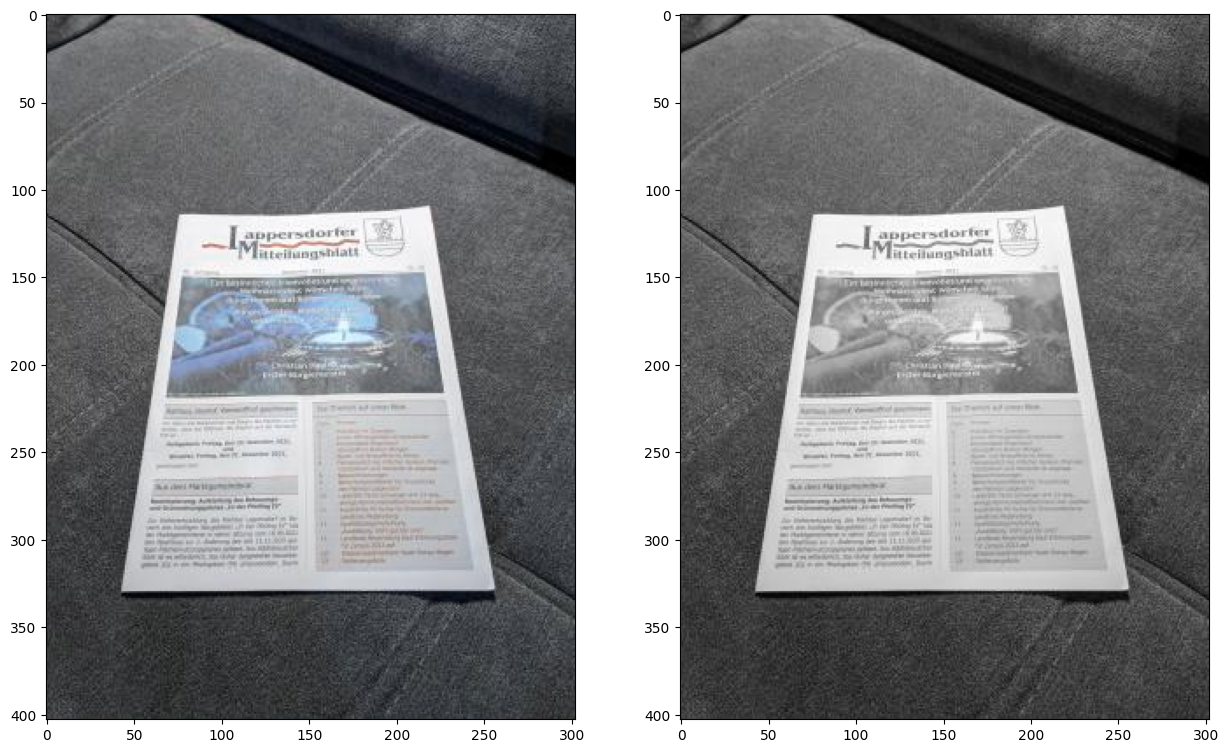

In [2]:
# Let's read the image
img = cv2.imread('document.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

In [3]:
# Compute Harris corners
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# Normalize the corner response to 0-255 scale
dst_norm = np.empty(dst.shape, dtype=np.float32)
cv2.normalize(dst, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Convert to uint8
dst_norm = np.uint8(dst_norm)

# Threshold for an optimal value, it may vary depending on the image
threshold = 0.1 * dst_norm.max()

# Create an image with Harris corners
cornerness = np.zeros_like(dst_norm)
cornerness[dst_norm > threshold] = 255

(<Axes: >, <matplotlib.image.AxesImage at 0x1aa11302fd0>)

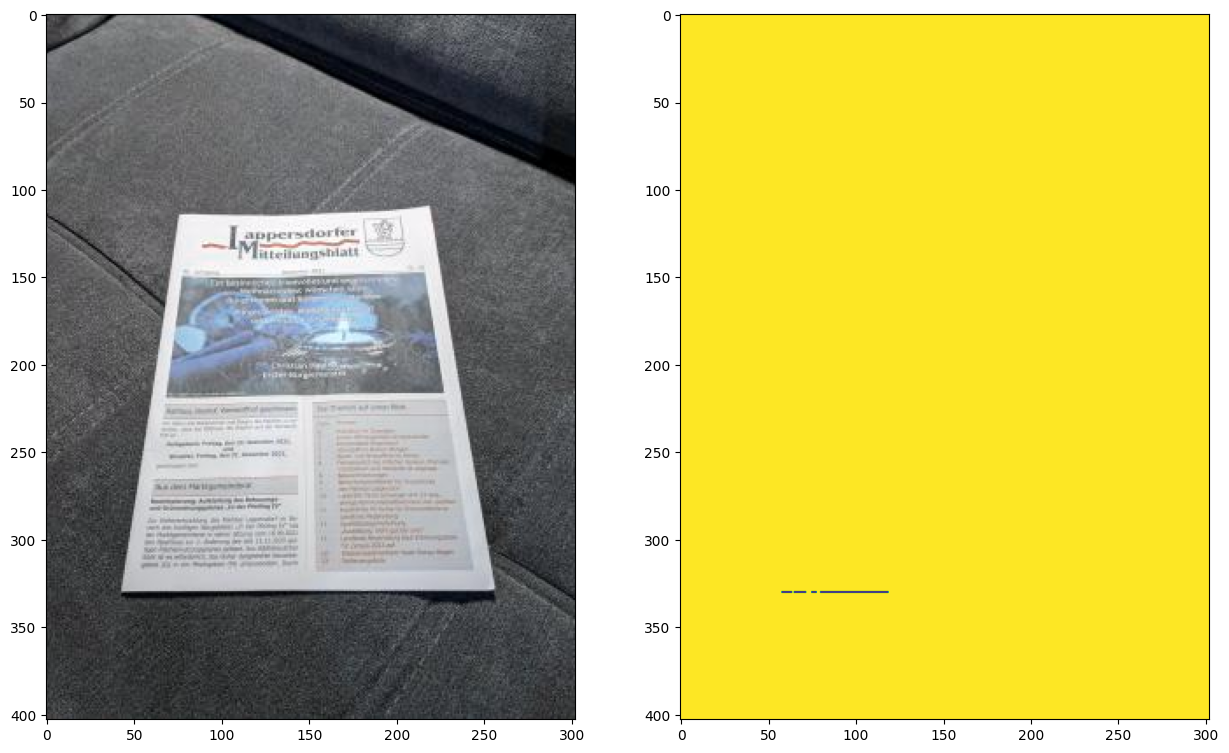

In [4]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

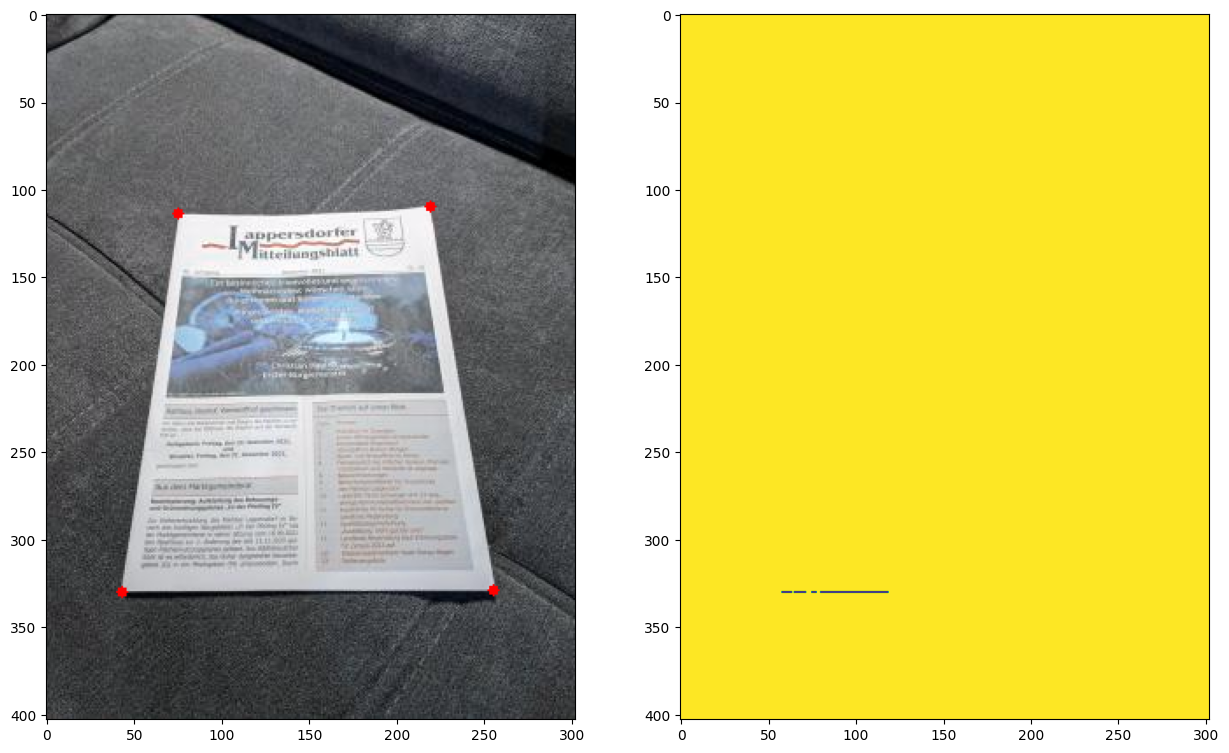

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 7  # Change quad_size to a larger value if necessary

# Minimum threshold for corner descriptors
min_descriptor_threshold = 10

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue

        # Extract block consisting of 4 quadrants
        block = 255 * gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]

        # Extract the four quadrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, -quad_size:]
        quad_bottom_left = block[-quad_size:, 0:quad_size]
        quad_bottom_right = block[-quad_size:, -quad_size:]
        
        # Top-left corner descriptor
        descriptor_top_left = np.mean(quad_bottom_right) - \
                              np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor_top_left > th_top_left and np.all(quad_bottom_right >= 155) and np.all(quad_bottom_right <= 255):
            # We update the threshold
            th_top_left = descriptor_top_left
            # And we update the optimal location
            opt_top_left = (c, r)

        # Top-right corner descriptor
        descriptor_top_right = np.mean(quad_bottom_left) - \
                               np.mean(quad_top_right) - np.mean(quad_bottom_right) - np.mean(quad_top_left)

        if descriptor_top_right > th_top_right and np.all(quad_bottom_left >= 155) and np.all(quad_bottom_left <= 255):
            th_top_right = descriptor_top_right
            opt_top_right = (c, r)

        # Bottom-left corner descriptor
        descriptor_bottom_left = np.mean(quad_top_right) - \
                                  np.mean(quad_bottom_left) - np.mean(quad_bottom_right) - np.mean(quad_top_left)

        if descriptor_bottom_left > th_bottom_left:
            th_bottom_left = descriptor_bottom_left
            opt_bottom_left = (c, r)

       # Bottom-right corner descriptor
        descriptor_bottom_right = np.mean(quad_top_left) - \
                                   np.mean(quad_bottom_right) - np.mean(quad_bottom_left) - np.mean(quad_top_right)

        if descriptor_bottom_right > th_bottom_right:
            th_bottom_right = descriptor_bottom_right
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)
plt.show()


В комірці нижче просто спробувала по прикладу 3 лабораторної роботи паралельно пробувати методи з бібліотек. Порівняно з попереднім методом ця комірка виконується в багато разів швидше.

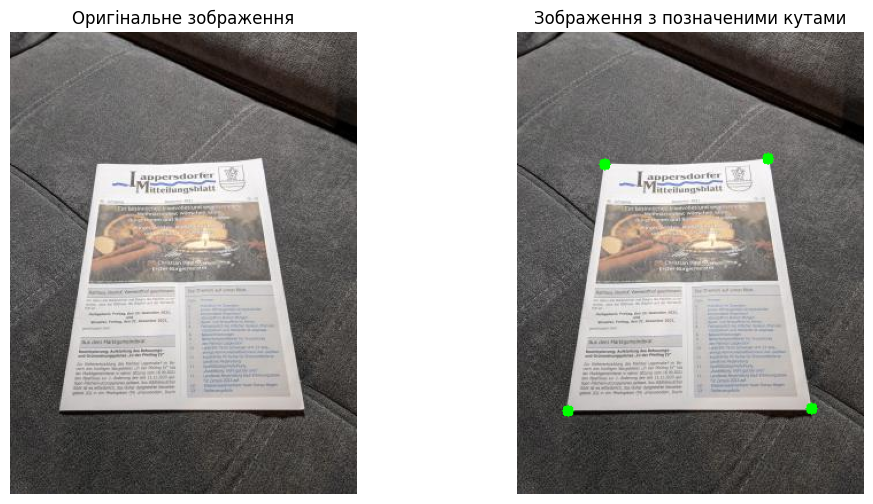

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_document_corners(image_path):
    # Завантажуємо зображення
    image = cv2.imread(image_path)
    
    # Перетворюємо зображення в відтінки сірого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Використовуємо фільтр Гауса для зменшення шуму
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Застосовуємо детектор країв Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    # Знаходимо контури на зображенні
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Сортуємо контури за їх площею та беремо найбільший контур
    contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    
    # Знаходимо відповідні кути контура
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    
    # Копіюємо зображення для відображення кутів
    image_with_corners = image.copy()
    
    # Відображаємо кути на оригінальному зображенні
    for point in approx:
        x, y = point.ravel()
        cv2.circle(image_with_corners, (x, y), 5, (0, 255, 0), -1)
    
    # Показуємо оригінальне зображення та зображення з позначеними кутами за допомогою Matplotlib
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Оригінальне зображення')
    ax1.axis('off')
    ax2.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))
    ax2.set_title('Зображення з позначеними кутами')
    ax2.axis('off')
    plt.show()

# Викликаємо функцію для зображення "example.jpg"
find_document_corners("document.jpg")
